In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, pickle
import sys
from skimage import io
import os

sys.path.append("../../")


%load_ext autoreload
%autoreload 2
%matplotlib inline

Load Dataset

In [2]:
# data_dir = '/data/natalia/intern20/PaperData/cellpose/' ## This should be the file where the .npz files are

data_dir = '/nadeem_lab/Gunjan/data/impartial/cellpose/'

pd_file = pd.read_csv(data_dir + 'files.csv')
pd_file['input_dir'] = data_dir
pd_file.to_csv(data_dir + 'files.csv')

print(pd_file) 
print()

#get number of instances per segmentation class
for i in range(len(pd_file)):
    group = pd_file['group'][i]
    print(data_dir + pd_file['input_file'][i])
    npz_read = np.load(data_dir + pd_file['input_file'][i])
    image = npz_read['image']        
    label = npz_read['label']
    
    #initialize lists
    if i == 0:
        if len(label.shape)>2:
            nclasses = label.shape[-1]
        else:
            nclasses = 1
        nlabels_class_train_list = [0 for i in range(nclasses)]
        nlabels_class_test_list = [0 for i in range(nclasses)]
    
    if len(label.shape)>2:
        for ix in range(label.shape[-1]):
            if group == 'train':
                nlabels_class_train_list[ix] += np.unique(label[...,ix]).shape[0] - 1
            else:
                nlabels_class_test_list[ix] += np.unique(label[...,ix]).shape[0] - 1
    else: #only one class
        if group == 'train':
            nlabels_class_train_list[0] += np.unique(label).shape[0] - 1
        else:
            nlabels_class_test_list[0] += np.unique(label).shape[0] - 1
        

print()
print('----')
print('total train instances per class (',nclasses, 'classes)')
print(nlabels_class_train_list)
print('total test instances per class (',nclasses, 'classes)')
print(nlabels_class_test_list)

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0            0             0               0                 0   
1            1             1               1                 1   
2            2             2               2                 2   
3            3             3               3                 3   
4            4             4               4                 4   
..         ...           ...             ...               ...   
69          69            69              69                69   
70          70            70              70                70   
71          71            71              71                71   
72          72            72              72                72   
73          73            73              73                73   

    Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  \
0                    0                     0                       0   
1                    1                     1                   

Scribble Generation

In [3]:

nlabels_budget = 300 ## number of label's scribbles


from skimage import morphology

def erosion_labels(label,radius_pointer=1): 
    #needed to generate scribbles from boundaries since in many cases 
    #there is no background between different instances
    selem = morphology.disk(radius_pointer)
    mask = np.zeros_like(label)
    for vlabel in np.unique(label):
        if vlabel != 0:
            mask_label = np.zeros_like(label)
            mask_label[label == vlabel] = 1
            aux = morphology.dilation(mask_label, selem=selem)
            if np.unique(aux*label).shape[0] > 2: #overlaps with other label
                erode_label = morphology.erosion(mask_label, selem=selem)
                mask[erode_label>0] = vlabel
            else:
                mask[mask_label>0] = vlabel
    ## Image Corners
    mask[:,0:radius_pointer] = label[:,0:radius_pointer]
    mask[:,-radius_pointer-1:] = label[:,-radius_pointer-1:]
    mask[0:radius_pointer,:] = label[0:radius_pointer,:]
    mask[-radius_pointer-1:,:] = label[-radius_pointer-1:,:]
    return mask

In [4]:
def get_scribbles_mask(label_image, fov_box=(32, 32), max_labels=4,
                       radius_pointer=0, disk_scribble=False,
                       sample_back = False, previous_scribbles = None):
    mask_image = np.zeros_like(label_image)
    mask_image[label_image > 0] = 1.0

    nlabels = np.unique(label_image[label_image > 0]).shape[0]
    max_labels = np.minimum(max_labels, nlabels)

    exclude_labels = []
    if previous_scribbles is not None:
        exclude_labels = list(np.unique(label_image[(label_image > 0) & (previous_scribbles[...,0]>0)]))
        max_labels = np.minimum(max_labels, nlabels - len(exclude_labels))




    ### Set the instance scribble mask mask_sk
    mask_sk = morphology.skeletonize(mask_image) * mask_image
    if radius_pointer > 0:
        selem = morphology.disk(radius_pointer)
        mask_sk = morphology.dilation(mask_sk, selem=selem) * mask_image
    if disk_scribble:
        selem = morphology.disk(3)
        outline_arc = morphology.erosion(mask_image, selem=selem) - \
                      morphology.erosion(morphology.erosion(mask_image, selem=selem), selem=morphology.disk(1))
        if radius_pointer > 0:
            selem = morphology.disk(radius_pointer)
            outline_arc = morphology.dilation(outline_arc, selem=selem)

        mask_sk += outline_arc
        mask_sk[mask_sk > 0] = 1
        mask_sk = mask_sk * mask_image

    nbudget = max_labels + 0
    labels_image_res = np.array(label_image)

    back_aux = np.array(mask_image)
    back_aux = morphology.dilation(back_aux, selem=morphology.disk(4))

    fov_image_res = np.array(1-mask_image) * back_aux #background entre foreground
    fov_image_res = morphology.skeletonize(fov_image_res)

    # plt.figure(figsize=(10,5))
    # plt.subplot(1,2,1)
    # plt.imshow(fov_image_res)
    # plt.subplot(1, 2, 2)

    back_aux = morphology.skeletonize(1-back_aux)
    fov_image_res += morphology.dilation(back_aux, selem=morphology.disk(4))

    # plt.imshow(fov_image_res)
    # plt.show()

    foreground = np.zeros_like(labels_image_res)
    background = np.zeros_like(labels_image_res)

    ## remove from labels_image_res labels to exclude:
    if len(exclude_labels) > 0:

        label_aux = np.zeros_like(labels_image_res)
        for label in exclude_labels:
            label_aux[labels_image_res == label] = 1

        labels_image_res = labels_image_res * (1 - label_aux)
        fov_image_res = fov_image_res * (1 - label_aux) #dont know if this is necessary
    #
    # plt.figure(figsize=(15, 5))
    # plt.subplot(1,3,1)
    # plt.imshow(fov_image_res)
    # plt.subplot(1, 3, 2)
    # plt.imshow(labels_image_res)
    # plt.subplot(1, 3, 3)
    # plt.imshow(label_image)
    # plt.show()

    while nbudget > 0:

        ## Pick a point at random
        if sample_back:
            aux = np.array(fov_image_res)
        else:
            aux = np.array(labels_image_res)

        ix0_back, ix1_back = np.nonzero(aux)
        ix = np.random.randint(0, ix0_back.shape[0])

        # bounding box
        xmin = np.maximum(0, ix0_back[ix] - int(fov_box[0] / 2))
        xmax = np.minimum(xmin + int(fov_box[0]), labels_image_res.shape[0])

        ymin = np.maximum(0, ix1_back[ix] - int(fov_box[1] / 2))
        ymax = np.minimum(ymin + int(fov_box[1]), labels_image_res.shape[0])

        bb_image = np.zeros_like(labels_image_res)
        bb_image[xmin:xmax, ymin:ymax] = 1

        active_labels = labels_image_res * bb_image

        if np.sum(active_labels>0)>0:
            active_labels = np.unique(active_labels[active_labels > 0])

            for label in active_labels:
                label_aux = np.zeros_like(labels_image_res)
                label_aux[labels_image_res == label] = 1

                ## foreground
                foreground += label_aux * mask_sk

                back_aux = morphology.dilation(label_aux, selem=morphology.disk(4))
                back_aux += bb_image
                back_aux = back_aux * (1 - mask_image)
                back_aux[back_aux > 0] = 1
                back_aux = morphology.skeletonize(back_aux)

                if radius_pointer > 0:
                    selem = morphology.disk(radius_pointer)
                    back_aux = morphology.dilation(back_aux, selem=selem) * (1 - mask_image)

                background += back_aux * (1 - mask_image)  # double secure

                nbudget -= 1
                labels_image_res = labels_image_res * (1 - label_aux)
                fov_image_res = fov_image_res * (1 - label_aux)
        else:
            # print('NO labels')
            if (np.sum(fov_image_res*bb_image)>0):
                back_aux = morphology.skeletonize(bb_image*(1-mask_image)*fov_image_res) ## box with background
                if radius_pointer > 0:
                    selem = morphology.disk(radius_pointer)
                    back_aux = morphology.dilation(back_aux, selem=selem) * (1 - mask_image)
                background += back_aux * (1 - mask_image)  # double secure
                # ix0_nonz, ix1_nonz = np.nonzero(back_aux)
                # # if radius_pointer > 0:
                # w=15
                # back_aux = np.zeros_like(back_aux)
                # back_aux[ix0_nonz[0],ix1_nonz[0]-w:ix1_nonz[0]+w] = 1
                # # selem[:,int(fov_box[1] / 2)] = 1
                #
                # # back_aux = morphology.dilation(back_aux, selem=selem) * (1 - mask_image)

        fov_image_res = fov_image_res * (1 - bb_image)

        foreground[foreground>0] = 1
        background[background>0] = 1

        print('budget : ', nbudget)

    mask_scribbles = np.zeros([mask_image.shape[0], mask_image.shape[1], 2])
    mask_scribbles[..., 0] = np.array(foreground)  # fore
    mask_scribbles[..., 1] = np.array(background)   # back

    if previous_scribbles is not None:
        print('Merging with previous scribbles')
        mask_scribbles = mask_scribbles + previous_scribbles
        mask_scribbles[mask_scribbles>0] = 1


    nscribbles = np.unique(label_image[(label_image > 0) & (mask_scribbles[...,0]>0)]).shape[0] - len(exclude_labels)



    return mask_scribbles, nscribbles, nlabels


def get_scribbles(train_masks, n_labels_total, fov_box=(32, 32),
                  radius_pointer=0,
                  disk_scribble=False,
                  sample_back = False,
                  previous_scribbles = None):

    nlabels_budget = n_labels_total + 0

    # first sample order from image with less to more number of labels in total
    nlabels_total_array = np.zeros([len(train_masks)])
    for i in range(len(train_masks)):
        label_image = np.array(train_masks[i])
        nlabels_total_array[i] = np.unique(label_image).shape[0]-1
    print('total labels per sample (image): ' ,nlabels_total_array)
    ## order based on number of labels so that the last has the more number of labels if more scribbles are needed for the budget
    ix_order = np.argsort(nlabels_total_array)

    Y_out_dic = {}
    nlabels_dic = {}
    nlabels_total_dic = {}
    print('sample_i,nbudget,nscribbles')
    for ix in range(len(train_masks)):
        i = ix_order[ix]
        label_image = np.array(train_masks[i])
        n_labels_i = np.maximum(2, int(nlabels_budget / (len(train_masks) - ix)))  # budget for i

        if previous_scribbles is not None:
            previous_scribbles_i = np.array(previous_scribbles[i])
        else:
            previous_scribbles_i = None

        print(i,nlabels_budget,n_labels_i)
        mask_scribbles, nscribbles, nlabels = get_scribbles_mask(label_image, fov_box=fov_box,
                                                                 max_labels=n_labels_i,
                                                                 radius_pointer=radius_pointer,
                                                                 disk_scribble=disk_scribble,
                                                                 sample_back = sample_back,
                                                                 previous_scribbles = previous_scribbles_i)

        nlabels_budget -= nscribbles
        Y_out_dic[i]= mask_scribbles
        nlabels_dic[i] = nscribbles
        nlabels_total_dic[i] = nlabels

    Y_out = []
    nlabels_list = []
    nlabels_total_list = []

    # reorder to original ordering
    for i in range(len(train_masks)):
        Y_out.append(Y_out_dic[i])
        nlabels_list.append(nlabels_dic[i])
        nlabels_total_list.append(nlabels_total_dic[i])

    return Y_out, nlabels_list, nlabels_total_list

/nadeem_lab/Gunjan/data/impartial/cellpose/000_img_cellpose_train_folder.npz


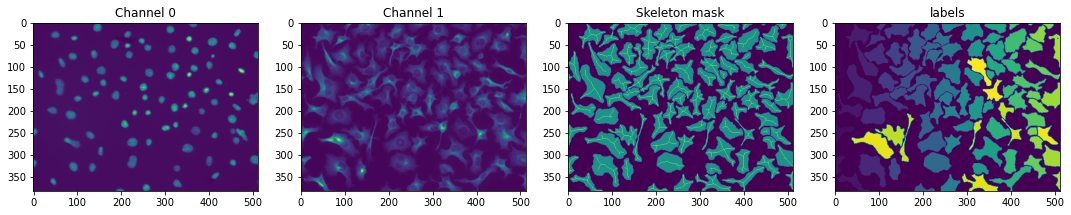

/nadeem_lab/Gunjan/data/impartial/cellpose/003_img_cellpose_train_folder.npz


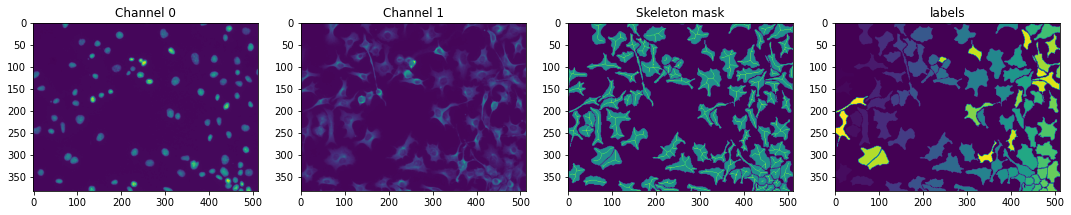

/nadeem_lab/Gunjan/data/impartial/cellpose/006_img_cellpose_train_folder.npz


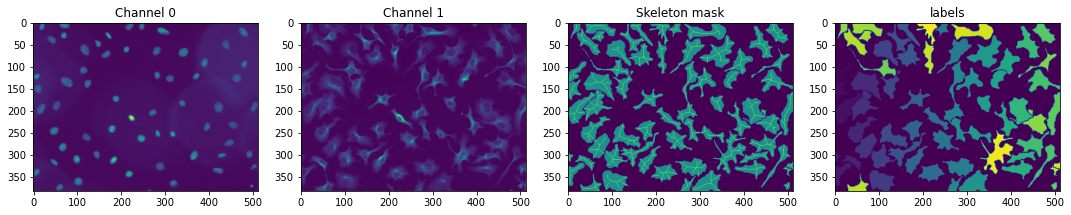

/nadeem_lab/Gunjan/data/impartial/cellpose/009_img_cellpose_train_folder.npz


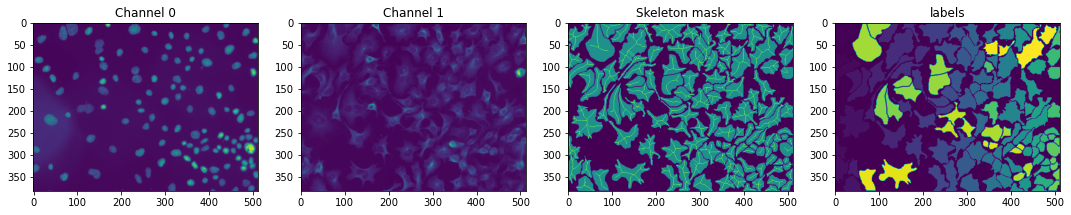

/nadeem_lab/Gunjan/data/impartial/cellpose/019_img_cellpose_train_folder.npz


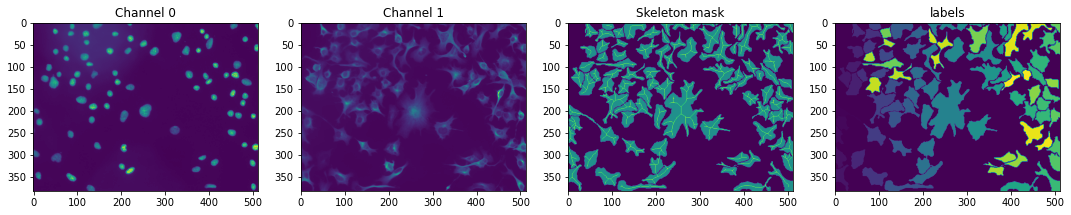

/nadeem_lab/Gunjan/data/impartial/cellpose/035_img_cellpose_train_folder.npz


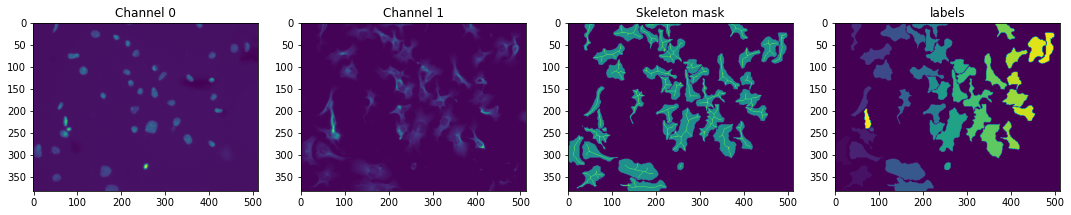

/nadeem_lab/Gunjan/data/impartial/cellpose/039_img_cellpose_train_folder.npz


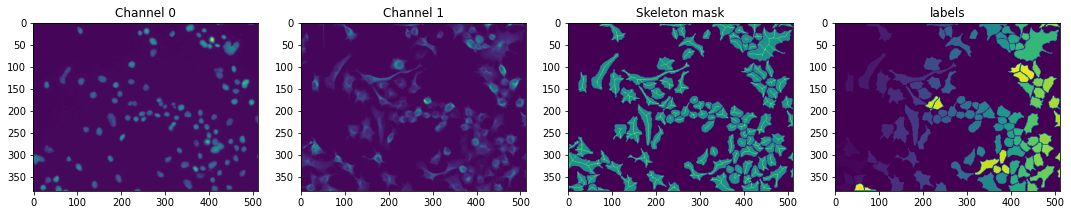

/nadeem_lab/Gunjan/data/impartial/cellpose/096_img_cellpose_train_folder.npz


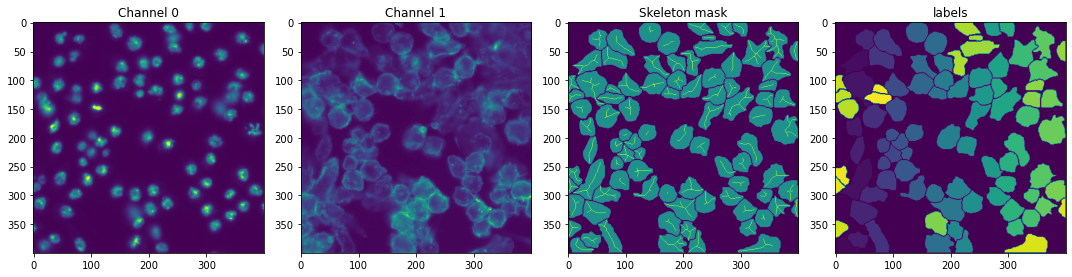

/nadeem_lab/Gunjan/data/impartial/cellpose/099_img_cellpose_train_folder.npz


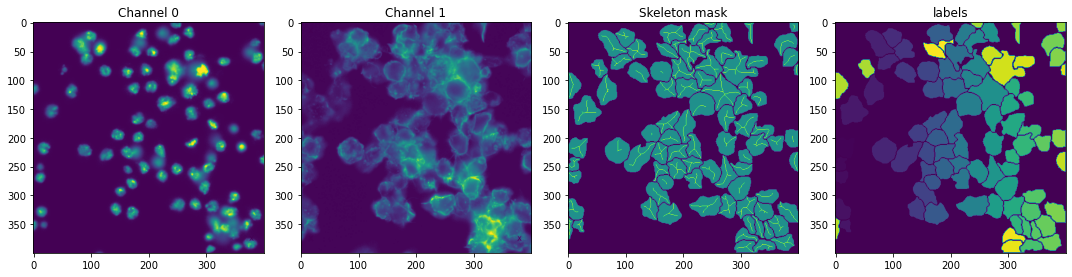

/nadeem_lab/Gunjan/data/impartial/cellpose/102_img_cellpose_train_folder.npz


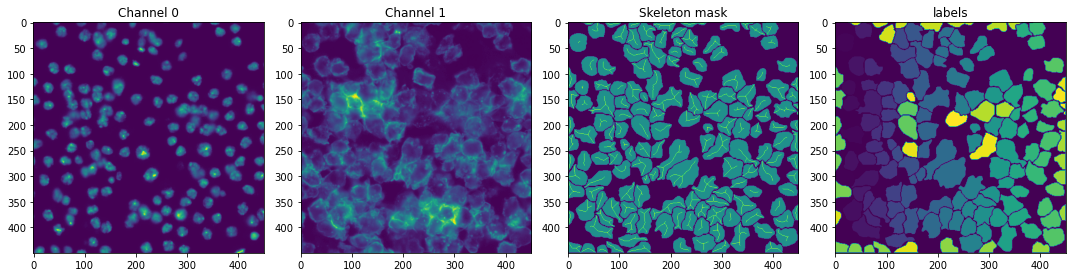

In [5]:
from skimage import morphology
# from dataprocessing.labelgeneration import get_scribbles

#load train segmentations in a list
X_train_list = []

Y_gt_train_ch0_list = []

files_train_list_aux = []

nlabels_total0 = 0

for i in range(len(pd_file)):
    group = pd_file['group'][i]
    if group == 'train':

        # print(pd_file['input_dir'][i] + pd_file['input_file'][i])
        # npz_read = np.load(pd_file['input_dir'][i] + pd_file['input_file'][i])
        
        print( data_dir + pd_file['input_file'][i])
        npz_read = np.load(data_dir + pd_file['input_file'][i])
        image = npz_read['image']        
        label0 = npz_read['label']
        label0 = erosion_labels(label0,radius_pointer=1)
        nlabels_total0 += np.unique(label0).shape[0]-1
        
        X_train_list.append(image)
        Y_gt_train_ch0_list.append(label0)
        
        files_train_list_aux.append([data_dir,
                                 pd_file['input_file'][i],
                                 pd_file['prefix'][i],])

        #nuclei mask
        nuclei0 = np.zeros_like(label0)
        nuclei0[label0>0] = 1

        plt.figure(figsize=(15,5))
        
        plt.subplot(1,4,1)
        plt.title('Channel 0')
        plt.imshow(image[...,0])
        
        plt.subplot(1,4,2)
        plt.title('Channel 1')
        plt.imshow(image[...,1])
        
        plt.subplot(1,4,3)
        skeleton = morphology.skeletonize(nuclei0)
        plt.title('Skeleton mask')
        plt.imshow(nuclei0+skeleton)
        
        plt.subplot(1,4,4)
        skeleton = morphology.skeletonize(nuclei0)
        plt.title('labels')
        plt.imshow(label0)
        
        plt.tight_layout()
        plt.show()

In [6]:
nbudget_list = [100,100,100]
Y_out_ch0_meta_list = []
nscribbles_ch0_meta_list = []
nlabels_ch0_meta_list = []

for i in range(len(nbudget_list)):

    np.random.seed(43)
    
    previous_scribbles =  None
    if i>0:
        previous_scribbles = Y_out_ch0_meta_list[i-1]

    
    ### whole object scribbles (ch0) (the only available in this dataset)
    Y_out_ch0_list, nscribbles_ch0_list, nlabels_ch0_list = get_scribbles(Y_gt_train_ch0_list[0:],
                                                                         nbudget_list[i],
                                                                         fov_box=(32,32),
                                                                         radius_pointer=0,
                                                                         disk_scribble = True,
                                                                         sample_back = True,
                                                                         previous_scribbles = previous_scribbles)
    
    Y_out_ch0_meta_list.append(Y_out_ch0_list) 
    nscribbles_ch0_meta_list.append(nscribbles_ch0_list) #contain new scribbles 
    nlabels_ch0_meta_list.append(nlabels_ch0_list)

total labels per sample (image):  [ 90.  94.  65. 121.  90.  40. 111.  88.  86. 154.]
sample_i,nbudget,nscribbles
5 100 10
budget :  8
budget :  5
budget :  3
budget :  1
budget :  0
2 90 10
budget :  7
budget :  7
budget :  6
budget :  4
budget :  2
budget :  -2
8 78 9
budget :  9
budget :  7
budget :  6
budget :  6
budget :  4
budget :  3
budget :  2
budget :  0
7 69 9
budget :  9
budget :  7
budget :  3
budget :  0
0 60 10
budget :  8
budget :  6
budget :  5
budget :  4
budget :  2
budget :  0
4 50 10
budget :  5
budget :  2
budget :  0
1 40 10
budget :  8
budget :  8
budget :  8
budget :  6
budget :  4
budget :  2
budget :  0
6 30 10
budget :  8
budget :  8
budget :  8
budget :  4
budget :  2
budget :  -1
3 19 9
budget :  6
budget :  4
budget :  2
budget :  0
9 10 10
budget :  6
budget :  3
budget :  -1
total labels per sample (image):  [ 90.  94.  65. 121.  90.  40. 111.  88.  86. 154.]
sample_i,nbudget,nscribbles
5 100 10
budget :  10
budget :  10
budget :  10
budget :  10
budget

####################   TOTAL SCRIBBLES  100  ####################################
0 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '000_img_cellpose_train_folder.npz', '000_img_cellpose_train_folder']
000_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
139543 272 279
120 272 75 279
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/000_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


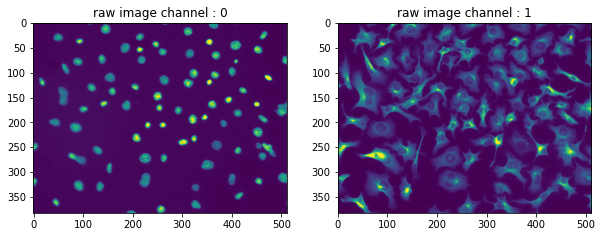

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


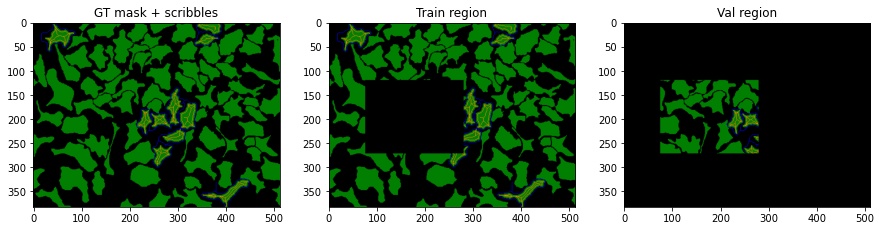

1 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '003_img_cellpose_train_folder.npz', '003_img_cellpose_train_folder']
003_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
86635 169 107
17 169 0 204
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/003_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


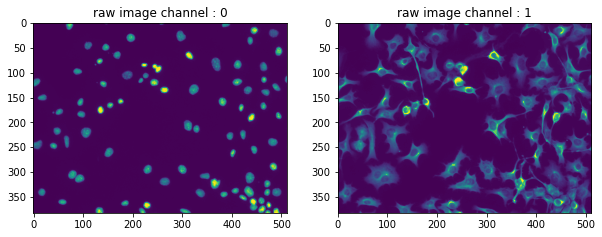

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


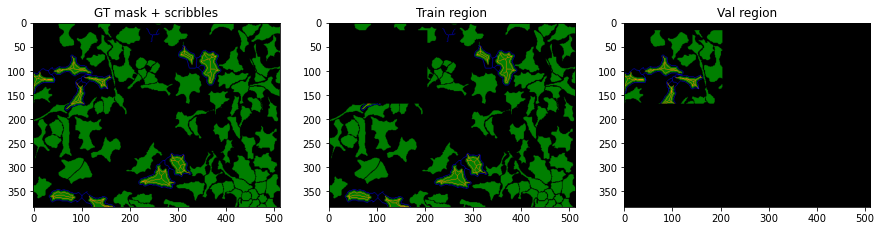

2 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '006_img_cellpose_train_folder.npz', '006_img_cellpose_train_folder']
006_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
117994 230 234
78 230 30 234
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/006_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


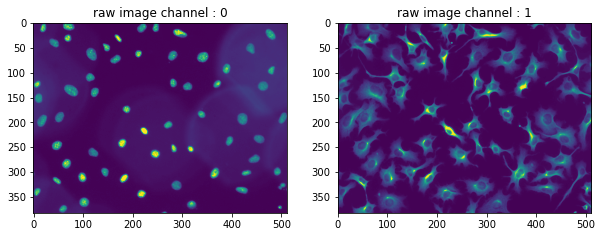

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


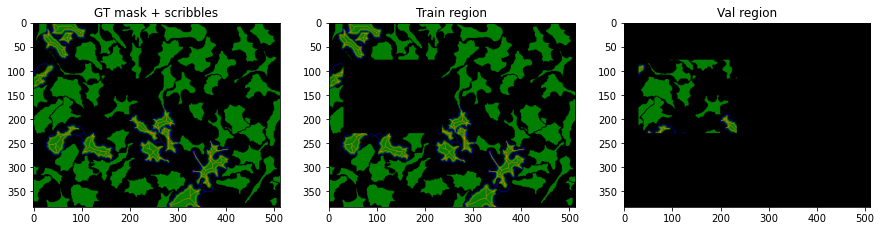

3 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '009_img_cellpose_train_folder.npz', '009_img_cellpose_train_folder']
009_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
146176 285 256
133 285 52 256
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/009_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


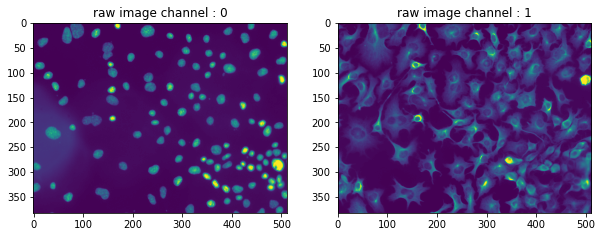

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


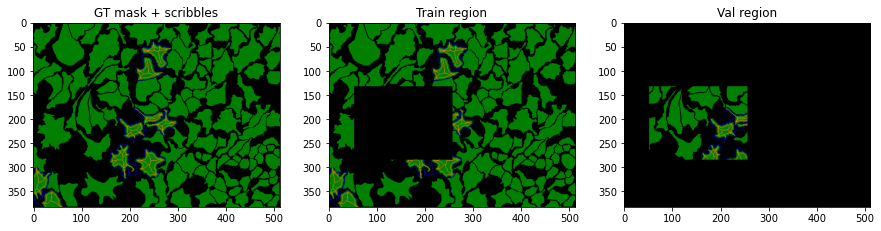

4 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '019_img_cellpose_train_folder.npz', '019_img_cellpose_train_folder']
019_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
11340 22 76
0 152 0 204
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/019_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


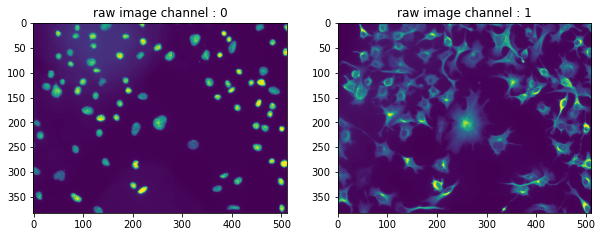

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


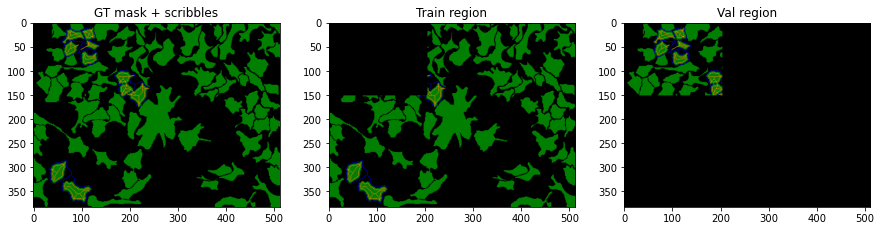

5 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '035_img_cellpose_train_folder.npz', '035_img_cellpose_train_folder']
035_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
51987 101 275
0 152 71 275
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/035_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


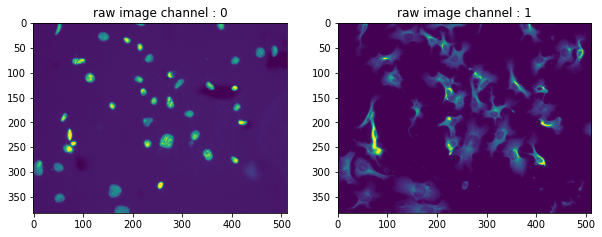

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


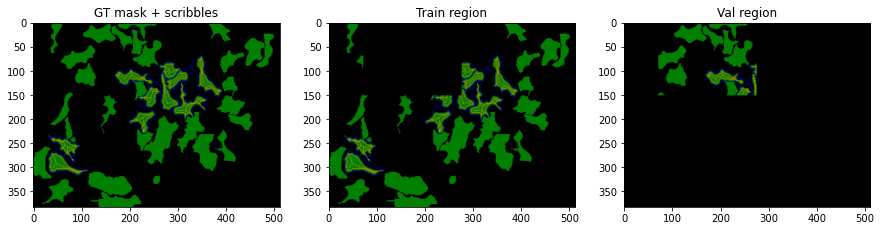

6 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '039_img_cellpose_train_folder.npz', '039_img_cellpose_train_folder']
039_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
64216 125 216
0 152 12 216
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/039_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


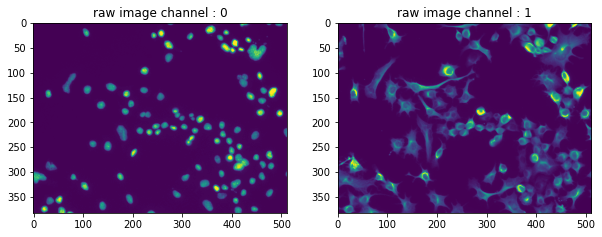

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


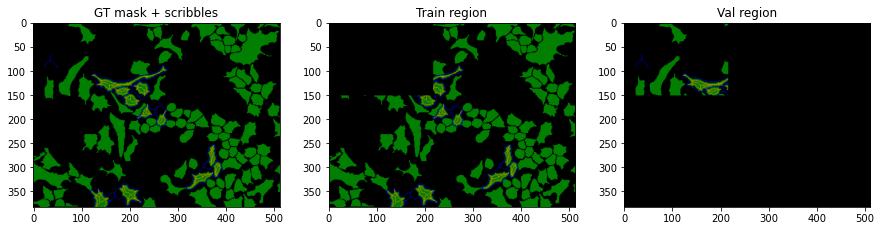

7 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '096_img_cellpose_train_folder.npz', '096_img_cellpose_train_folder']
096_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
32303 80 303
0 160 143 303
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/096_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


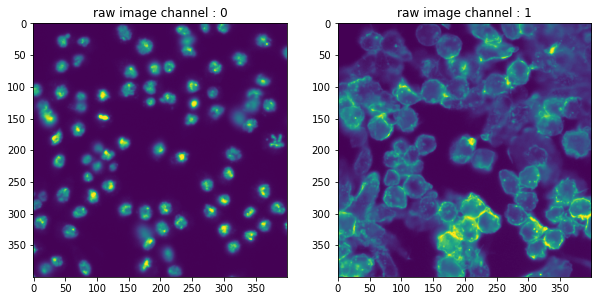

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


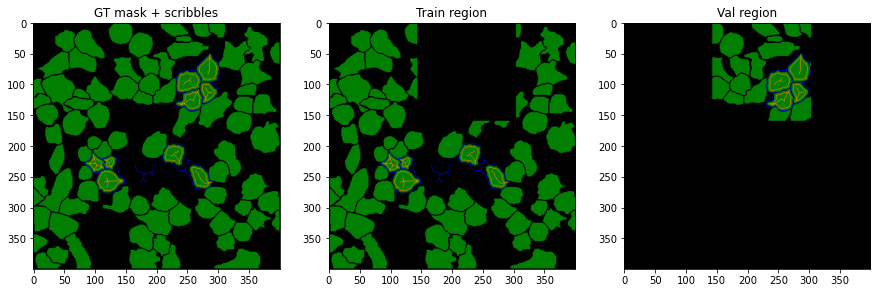

8 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '099_img_cellpose_train_folder.npz', '099_img_cellpose_train_folder']
099_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
67643 169 43
9 169 0 160
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/099_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


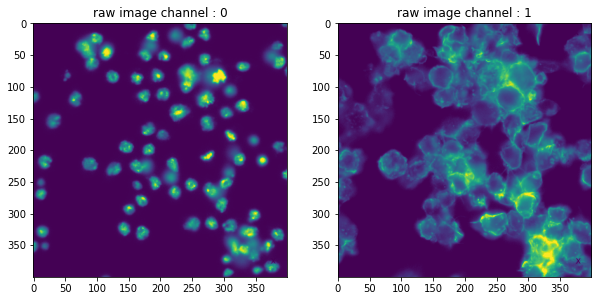

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


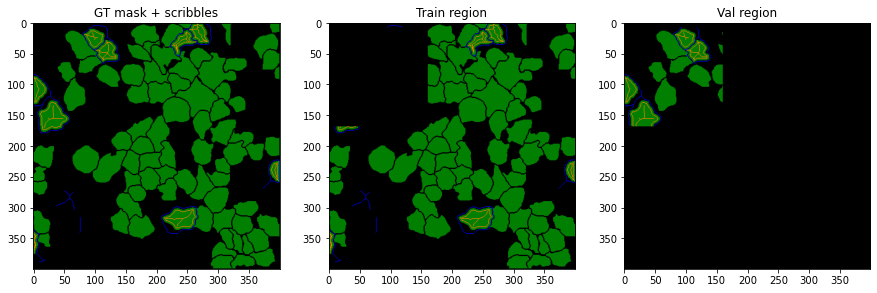

9 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '102_img_cellpose_train_folder.npz', '102_img_cellpose_train_folder']
102_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz
40670 90 170
0 180 0 180
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/102_img_cellpose_train_folder_1task1class_10images_cumscribble_n100.npz


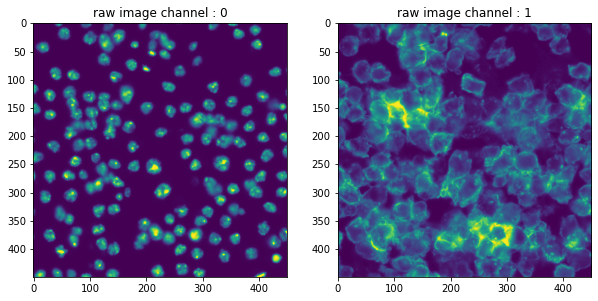

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


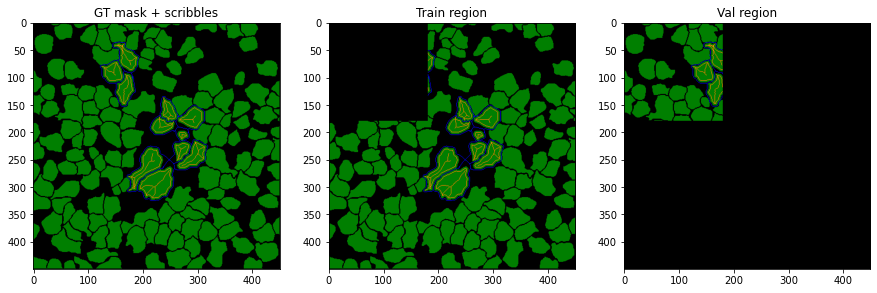

Saving in: 
/nadeem_lab/Gunjan/data/impartial/cellpose/files_train_1task1class_10images_cumscribble_n100.csv
                                     input_dir  \
0  /nadeem_lab/Gunjan/data/impartial/cellpose/   
1  /nadeem_lab/Gunjan/data/impartial/cellpose/   
2  /nadeem_lab/Gunjan/data/impartial/cellpose/   
3  /nadeem_lab/Gunjan/data/impartial/cellpose/   
4  /nadeem_lab/Gunjan/data/impartial/cellpose/   
5  /nadeem_lab/Gunjan/data/impartial/cellpose/   
6  /nadeem_lab/Gunjan/data/impartial/cellpose/   
7  /nadeem_lab/Gunjan/data/impartial/cellpose/   
8  /nadeem_lab/Gunjan/data/impartial/cellpose/   
9  /nadeem_lab/Gunjan/data/impartial/cellpose/   

                          input_file                         prefix  \
0  000_img_cellpose_train_folder.npz  000_img_cellpose_train_folder   
1  003_img_cellpose_train_folder.npz  003_img_cellpose_train_folder   
2  006_img_cellpose_train_folder.npz  006_img_cellpose_train_folder   
3  009_img_cellpose_train_folder.npz  009_img_cellpose_t

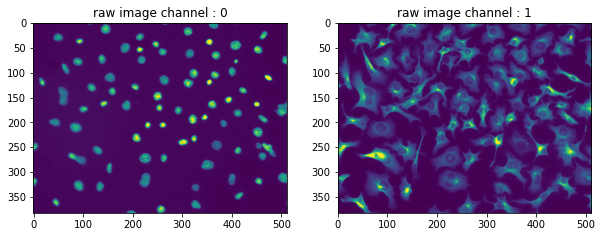

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


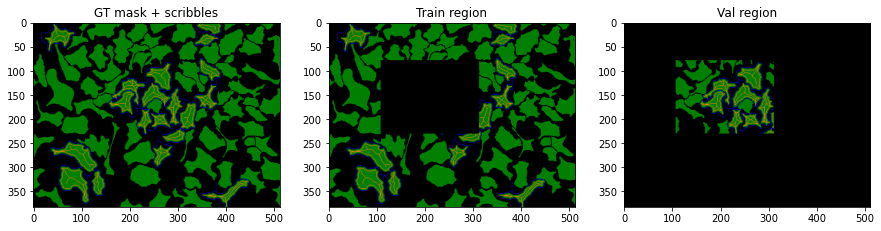

1 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '003_img_cellpose_train_folder.npz', '003_img_cellpose_train_folder']
003_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
59647 116 255
0 152 51 255
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/003_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


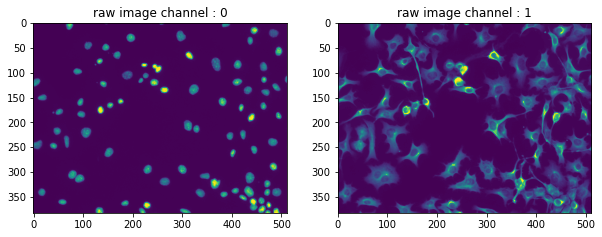

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


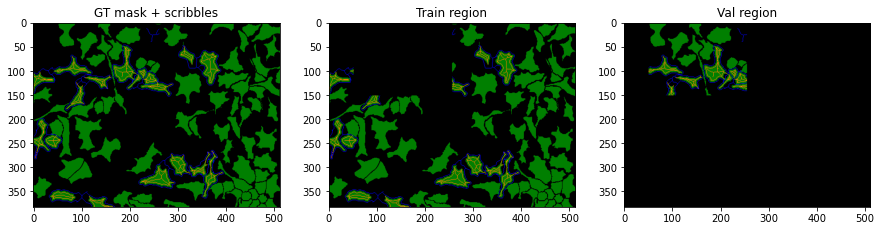

2 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '006_img_cellpose_train_folder.npz', '006_img_cellpose_train_folder']
006_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
114933 224 245
72 224 41 245
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/006_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


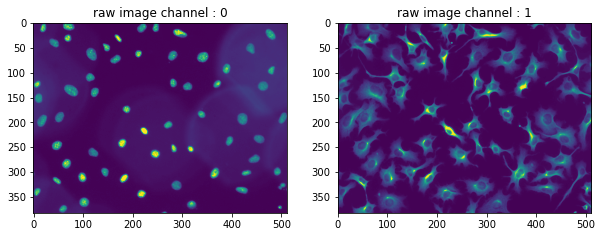

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


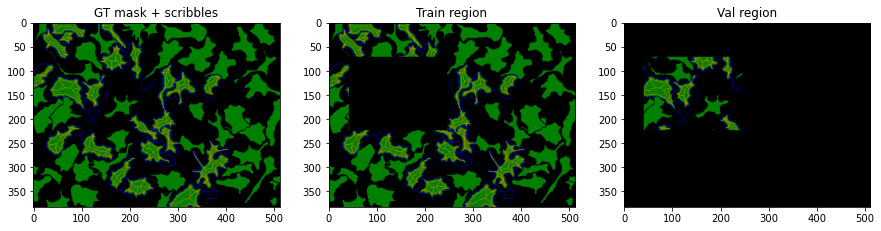

3 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '009_img_cellpose_train_folder.npz', '009_img_cellpose_train_folder']
009_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
162853 318 37
166 318 0 204
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/009_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


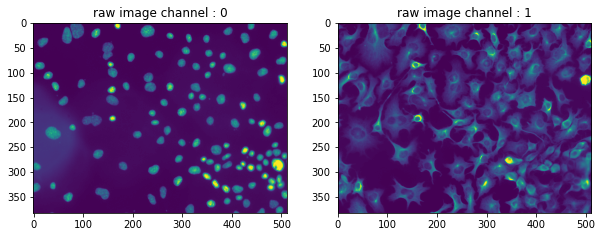

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


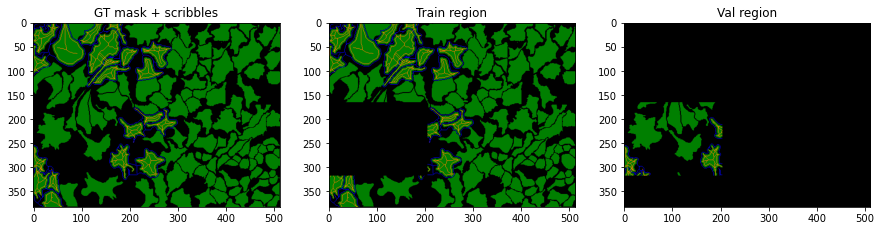

4 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '019_img_cellpose_train_folder.npz', '019_img_cellpose_train_folder']
019_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
58581 114 213
0 152 9 213
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/019_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


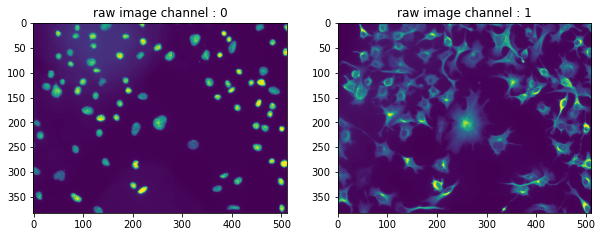

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


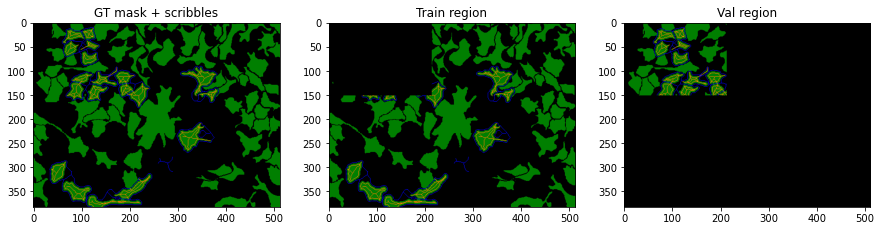

5 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '035_img_cellpose_train_folder.npz', '035_img_cellpose_train_folder']
035_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
69488 135 368
0 152 164 368
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/035_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


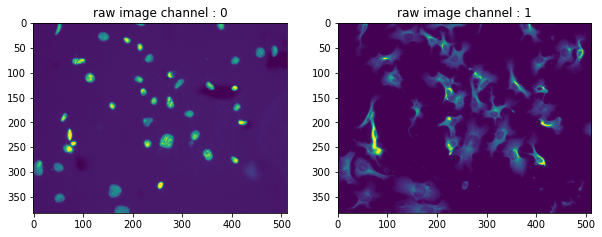

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


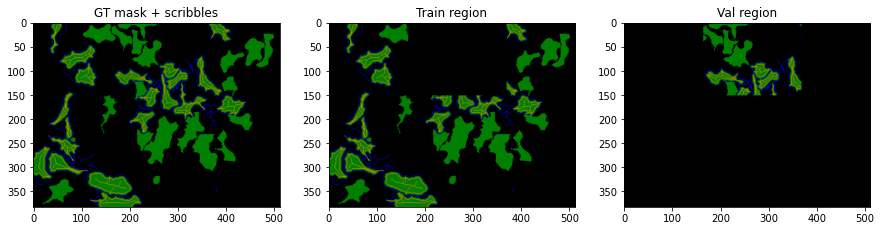

6 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '039_img_cellpose_train_folder.npz', '039_img_cellpose_train_folder']
039_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
54513 106 241
0 152 37 241
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/039_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


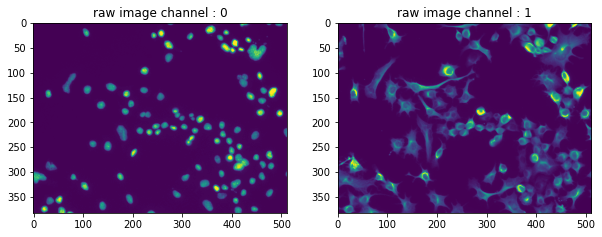

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


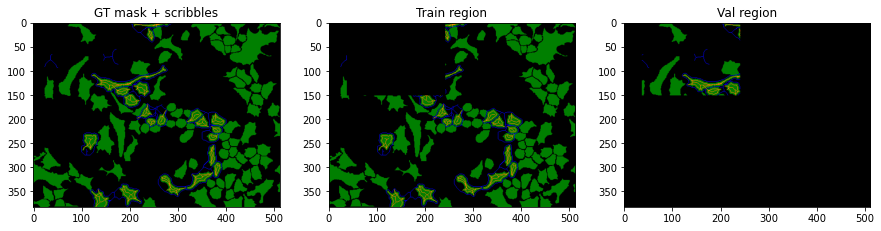

7 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '096_img_cellpose_train_folder.npz', '096_img_cellpose_train_folder']
096_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
93829 234 229
74 234 69 229
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/096_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


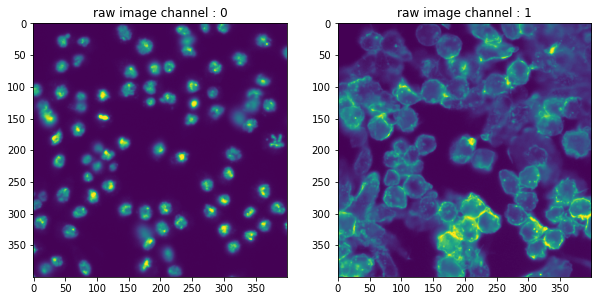

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


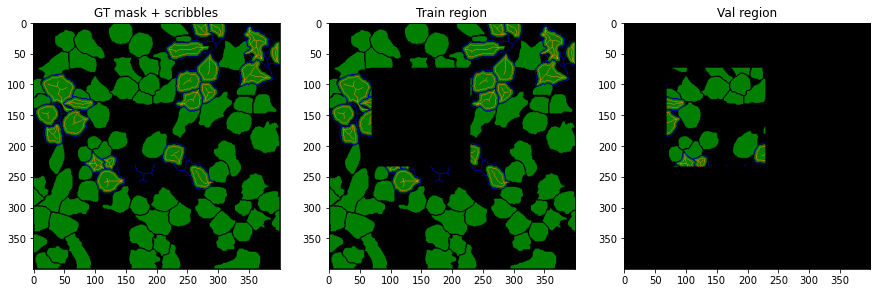

8 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '099_img_cellpose_train_folder.npz', '099_img_cellpose_train_folder']
099_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
21057 52 257
0 160 97 257
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/099_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


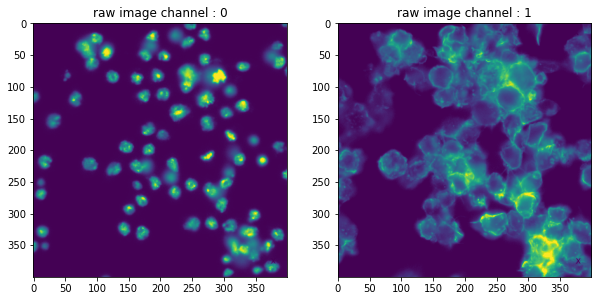

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


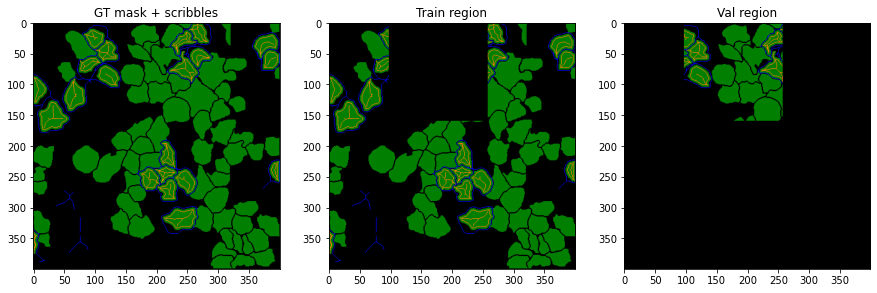

9 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '102_img_cellpose_train_folder.npz', '102_img_cellpose_train_folder']
102_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz
197250 438 150
258 438 0 180
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/102_img_cellpose_train_folder_1task1class_10images_cumscribble_n200.npz


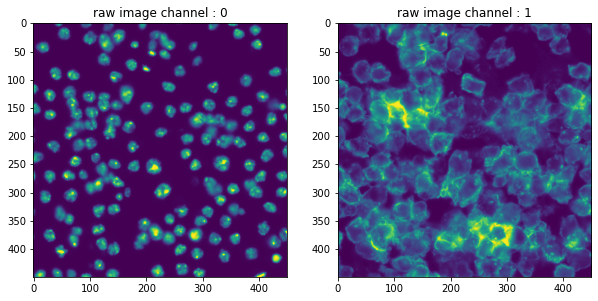

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


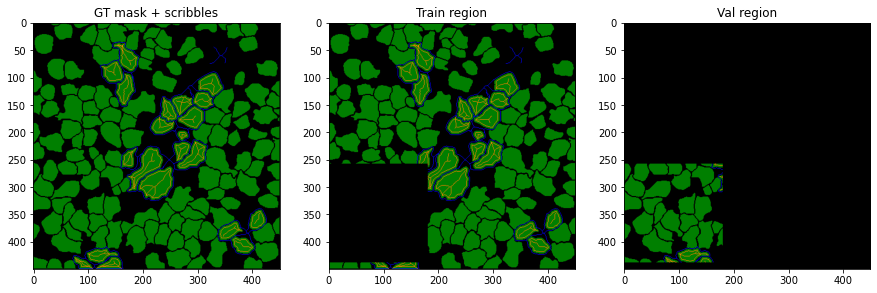

Saving in: 
/nadeem_lab/Gunjan/data/impartial/cellpose/files_train_1task1class_10images_cumscribble_n200.csv
                                     input_dir  \
0  /nadeem_lab/Gunjan/data/impartial/cellpose/   
1  /nadeem_lab/Gunjan/data/impartial/cellpose/   
2  /nadeem_lab/Gunjan/data/impartial/cellpose/   
3  /nadeem_lab/Gunjan/data/impartial/cellpose/   
4  /nadeem_lab/Gunjan/data/impartial/cellpose/   
5  /nadeem_lab/Gunjan/data/impartial/cellpose/   
6  /nadeem_lab/Gunjan/data/impartial/cellpose/   
7  /nadeem_lab/Gunjan/data/impartial/cellpose/   
8  /nadeem_lab/Gunjan/data/impartial/cellpose/   
9  /nadeem_lab/Gunjan/data/impartial/cellpose/   

                          input_file                         prefix  \
0  000_img_cellpose_train_folder.npz  000_img_cellpose_train_folder   
1  003_img_cellpose_train_folder.npz  003_img_cellpose_train_folder   
2  006_img_cellpose_train_folder.npz  006_img_cellpose_train_folder   
3  009_img_cellpose_train_folder.npz  009_img_cellpose_t

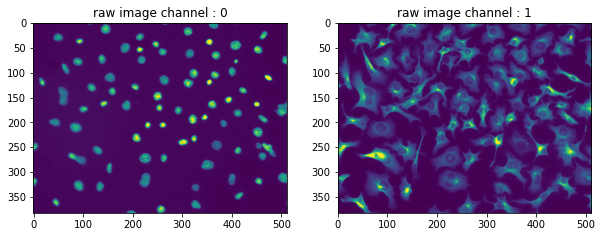

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


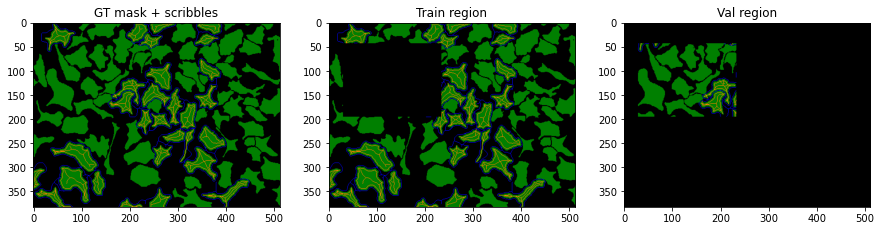

1 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '003_img_cellpose_train_folder.npz', '003_img_cellpose_train_folder']
003_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
122424 239 56
87 239 0 204
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/003_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


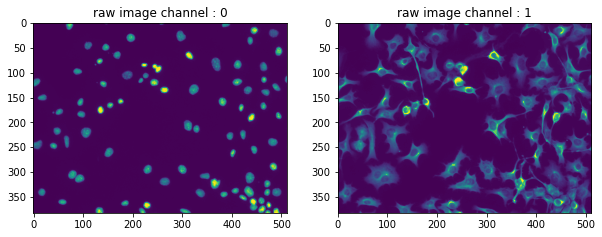

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


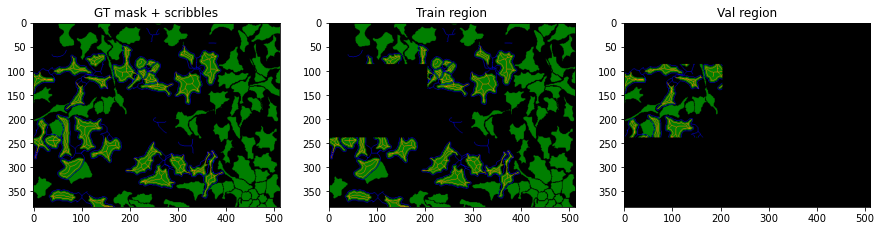

2 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '006_img_cellpose_train_folder.npz', '006_img_cellpose_train_folder']
006_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
136826 267 122
115 267 0 204
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/006_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


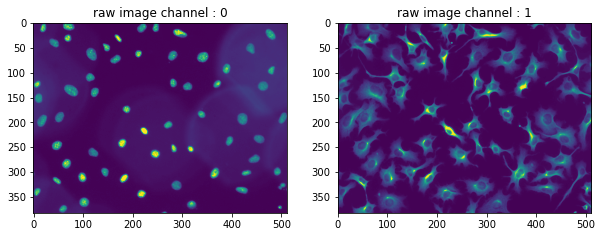

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


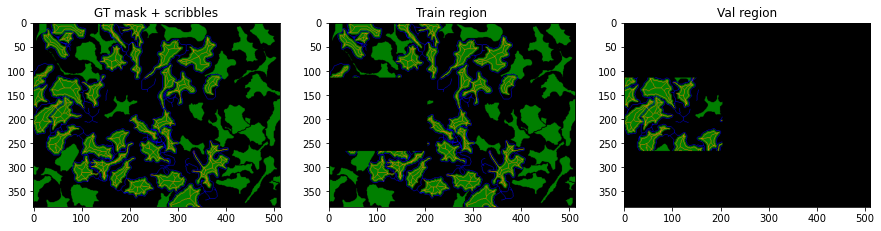

3 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '009_img_cellpose_train_folder.npz', '009_img_cellpose_train_folder']
009_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
135013 263 357
111 263 153 357
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/009_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


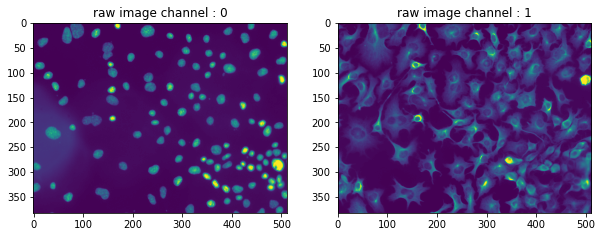

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


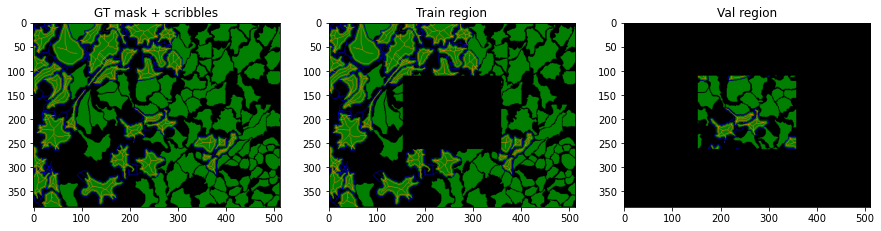

4 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '019_img_cellpose_train_folder.npz', '019_img_cellpose_train_folder']
019_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
127809 249 321
97 249 117 321
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/019_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


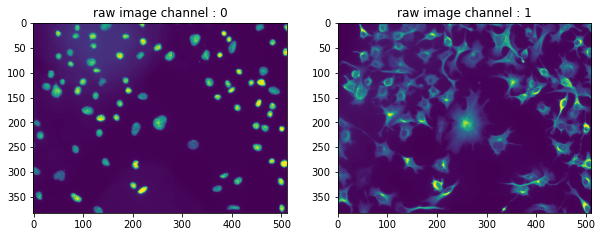

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


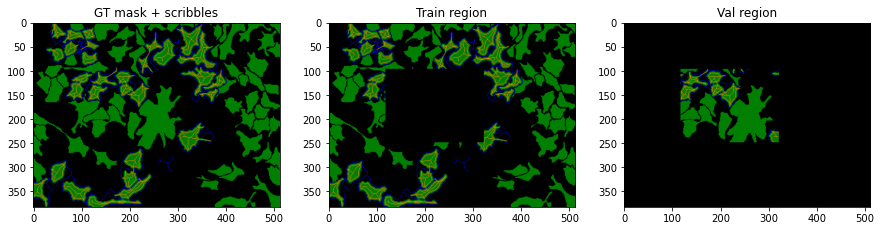

5 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '035_img_cellpose_train_folder.npz', '035_img_cellpose_train_folder']
035_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
130910 255 350
103 255 146 350
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/035_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


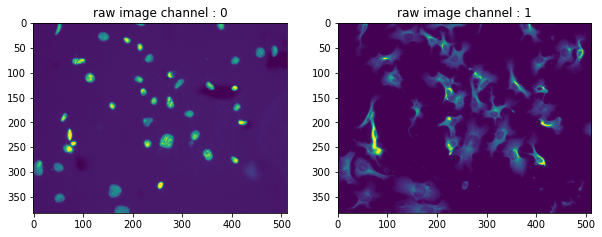

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


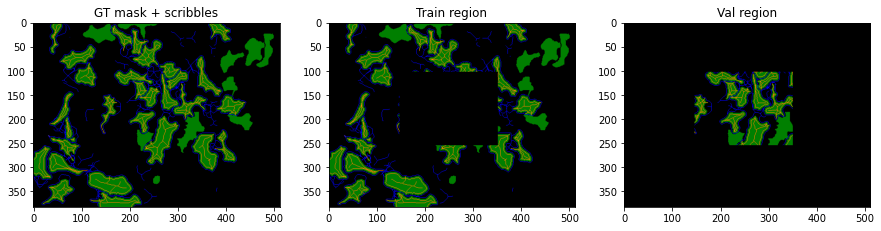

6 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '039_img_cellpose_train_folder.npz', '039_img_cellpose_train_folder']
039_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
16107 31 235
0 152 31 235
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/039_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


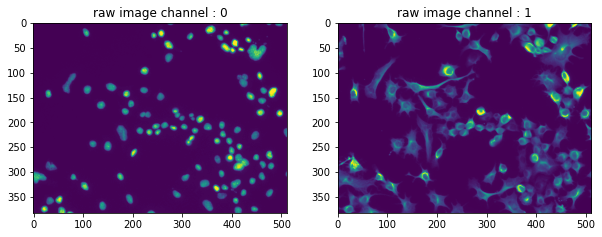

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


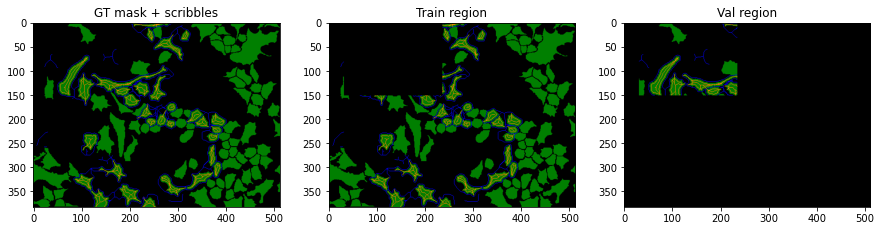

7 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '096_img_cellpose_train_folder.npz', '096_img_cellpose_train_folder']
096_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
104546 261 146
101 261 0 160
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/096_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


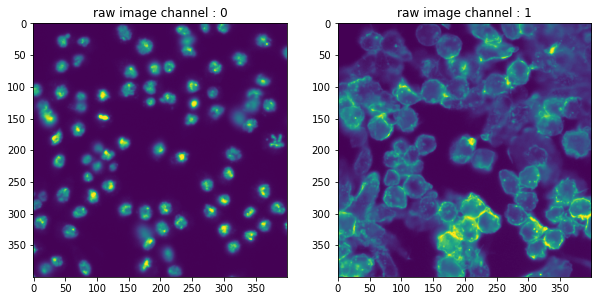

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


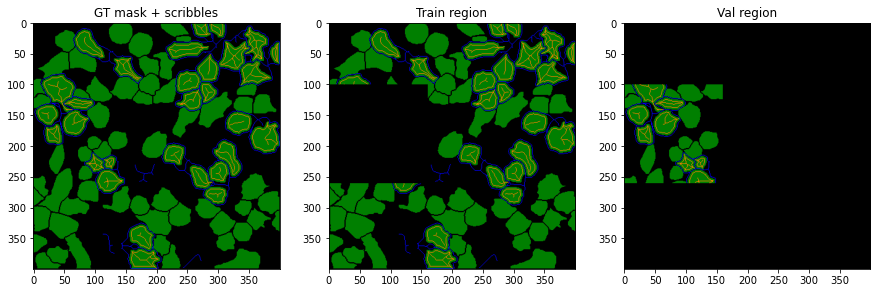

8 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '099_img_cellpose_train_folder.npz', '099_img_cellpose_train_folder']
099_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
30902 77 102
0 160 0 160
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/099_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


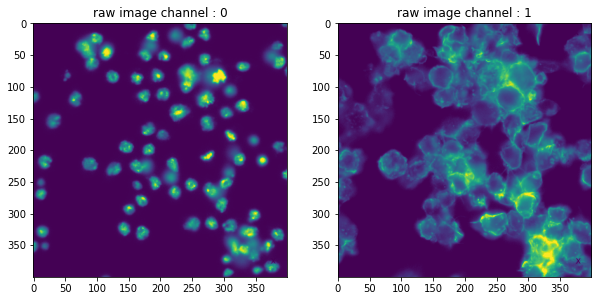

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


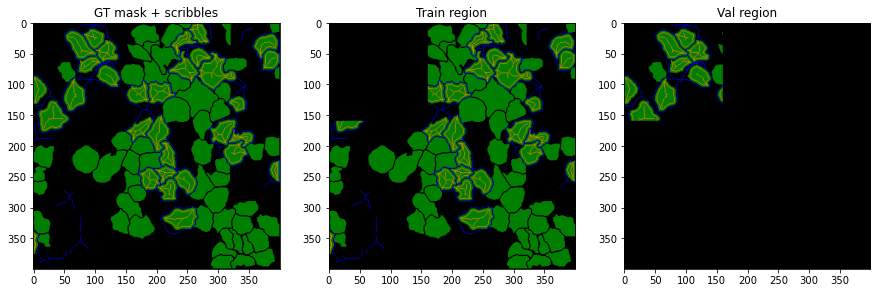

9 ['/nadeem_lab/Gunjan/data/impartial/cellpose/', '102_img_cellpose_train_folder.npz', '102_img_cellpose_train_folder']
102_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz
108296 240 296
60 240 116 296
check unique values scribbles : [0. 1.]
/nadeem_lab/Gunjan/data/impartial/cellpose/102_img_cellpose_train_folder_1task1class_10images_cumscribble_n300.npz


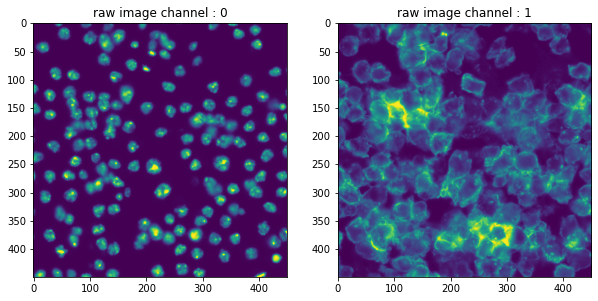

 task 0 ; classes : [0]
check sum of scribbles on same class (=1 or 0) : [0. 1.]


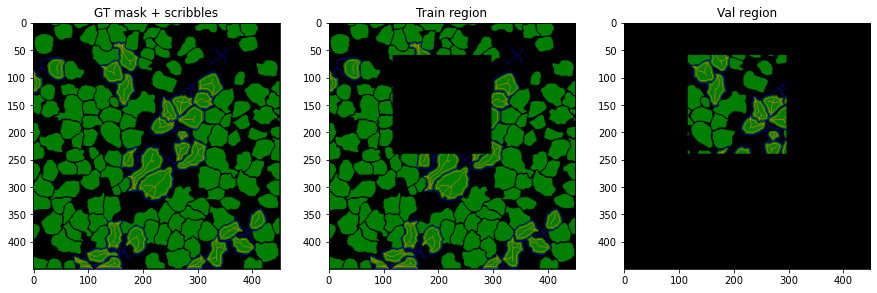

Saving in: 
/nadeem_lab/Gunjan/data/impartial/cellpose/files_train_1task1class_10images_cumscribble_n300.csv
                                     input_dir  \
0  /nadeem_lab/Gunjan/data/impartial/cellpose/   
1  /nadeem_lab/Gunjan/data/impartial/cellpose/   
2  /nadeem_lab/Gunjan/data/impartial/cellpose/   
3  /nadeem_lab/Gunjan/data/impartial/cellpose/   
4  /nadeem_lab/Gunjan/data/impartial/cellpose/   
5  /nadeem_lab/Gunjan/data/impartial/cellpose/   
6  /nadeem_lab/Gunjan/data/impartial/cellpose/   
7  /nadeem_lab/Gunjan/data/impartial/cellpose/   
8  /nadeem_lab/Gunjan/data/impartial/cellpose/   
9  /nadeem_lab/Gunjan/data/impartial/cellpose/   

                          input_file                         prefix  \
0  000_img_cellpose_train_folder.npz  000_img_cellpose_train_folder   
1  003_img_cellpose_train_folder.npz  003_img_cellpose_train_folder   
2  006_img_cellpose_train_folder.npz  006_img_cellpose_train_folder   
3  009_img_cellpose_train_folder.npz  009_img_cellpose_t

In [7]:
## Save scribbles
val_perc = 0.4
import copy
from csbdeep.utils import normalize

prefix_name = '1task1class_10images_cumscribble_'
pandas_file_list = []

nlabels_budget = 0
for ibudget in range(len(Y_out_ch0_meta_list)):
    Y_out_ch0_list = Y_out_ch0_meta_list[ibudget]
    nlabels_budget += nbudget_list[ibudget]
    nscribbles_ch0_list = nscribbles_ch0_meta_list[ibudget]
    nlabels_ch0_list = nlabels_ch0_meta_list[ibudget]
    
    files_train_list = copy.deepcopy(files_train_list_aux)
    
    np.random.seed(9)
    np.random.seed(44)
    
    print('####################   TOTAL SCRIBBLES ', nlabels_budget, ' ####################################')
    
    for i in range(len(files_train_list)):

        image = X_train_list[i]
        label_gt = Y_gt_train_ch0_list[i][...,np.newaxis] 
        scribbles_ch = [Y_out_ch0_list[i]]

        ### save scribbles file name
        print(i,files_train_list[i])
        name_save = files_train_list[i][1].split('.')[0] + '_'+prefix_name+'n'+str(int(nlabels_budget))+'.npz'
        print(name_save)
        files_train_list[i].extend([name_save])

        ### save number of labels with scribbles per channel
        for ch in np.arange(len(scribbles_ch)):
            label_ch = label_gt[...,ch]
            s_ch = scribbles_ch[ch]

            #nlabels with scribbles
            label_wscribble = np.unique(label_ch[s_ch[...,0]>0].flatten())
            nscribbles = label_wscribble.shape[0]
            nlabels = np.unique(label_ch[label_ch>0]).shape[0]
            pixels_scribbled_TP = np.round(100*np.sum(s_ch[...,0]>0)/ (np.sum(label_ch>0)),2)
            pixels_scribbled_TN = np.round(100*np.sum(s_ch[...,1]>0)/ (np.sum(label_ch==0)),2)
            files_train_list[i].extend([int(nlabels),int(nscribbles),
                                        label_wscribble,pixels_scribbled_TP,pixels_scribbled_TN])

        ### Define classification tasks and their scribbles
        tasks_classes = {'0':[0]}

        scribble = None
        for tasks in tasks_classes.keys():
            start_task = True
            for ch in tasks_classes[tasks]:

                s_ch = scribbles_ch[ch]

                label_ch = np.array(label_gt)
                label_ch[...,ch] = 0
                label_ch = label_ch[...,tasks_classes[tasks]]
                label_ch[label_ch>0] = 1
                label_ch = np.sum(label_ch,-1)

                if start_task:
                    background = np.array(s_ch[...,1])*(1-label_ch) + 0 #make sure no foreground is set as background
                    scribble_task = np.array(s_ch[...,0])[...,np.newaxis] + 0
                    start_task = False
                else:
                    background += np.array(s_ch[...,1])*(1-label_ch) #make sure no foreground is set as background
                    scribble_task = np.concatenate([scribble_task, np.array(s_ch[...,0])[...,np.newaxis]],axis = -1)

            scribble_task = np.concatenate([scribble_task,background[...,np.newaxis]],axis = -1)
            scribble_task[scribble_task>0] = 1

            if scribble is None:
                scribble = np.array(scribble_task)
            else:
                scribble = np.concatenate([scribble,scribble_task],axis = -1)


        ### validation sample region mask ###
        region_val_size = [int(image.shape[0] * val_perc/2),int(image.shape[1] * val_perc/2)] #validation region
        mask_scribbles = np.sum(scribble,axis = -1)
        mask_scribbles[mask_scribbles>0] = 1
        from scipy import ndimage
        mask_scribbles = ndimage.convolve(mask_scribbles, np.ones([5,5]), mode='constant', cval=0.0)
        #remove borders
    #     mask_scribbles[-region_val_size[0]:,:] = 0
    #     mask_scribbles[:,-region_val_size[1]:] = 0
    #     mask_scribbles[0:region_val_size[0],:] = 0
    #     mask_scribbles[:,0:region_val_size[1]] = 0
        val_center = np.random.multinomial(1, mask_scribbles.flatten()/np.sum(mask_scribbles.flatten()), size=1).flatten()
        ix_center = np.argmax(val_center)
        ix_row = int(np.floor(ix_center/image.shape[1]))
        ix_col = int(ix_center - ix_row * image.shape[1])
        print(ix_center,ix_row,ix_col)

        row_low = np.maximum(ix_row-region_val_size[0],0)
        row_high = np.minimum(row_low+region_val_size[0],image.shape[0])
        row_low = np.maximum(row_high - 2*region_val_size[0],0)
        row_high = np.minimum(row_low+ 2*region_val_size[0],image.shape[0])

        col_low = np.maximum(ix_col-region_val_size[1],0)
        col_high = np.minimum(col_low+region_val_size[1],image.shape[1])
        col_low = np.maximum(col_high - 2*region_val_size[1],0)
        col_high = np.minimum(col_low+2*region_val_size[1],image.shape[1])
        print(row_low,row_high,col_low,col_high)

        validation_mask = np.zeros([image.shape[0],image.shape[1]])
        validation_mask[row_low:row_high,
                        col_low:col_high] = 1
    #     validation_mask[ix_row-region_val_size[0]:ix_row+region_val_size[0],
    #                     ix_col-region_val_size[1]:ix_col+region_val_size[1]] = 1

        ## saving
        print('check unique values scribbles :',np.unique(scribble))
        print(files_train_list[i][0]+name_save)
        np.savez(files_train_list[i][0]+name_save,scribble=scribble,val_mask = validation_mask)

        ############################################# Plots #############################################
        #plot input channels
        plt.figure(figsize=(10,5))
        ix = 0
        for ch in range(image.shape[-1]):
            image_plot = normalize(image[...,ch],pmin=1,pmax=99.8,clip = True)
            plt.subplot(1,image.shape[-1],ix + 1)
            ix += 1
            plt.title('raw image channel : '+ str(ch))
            plt.imshow(image_plot)
        plt.show()

        itask = 0
        for tasks in tasks_classes.keys():
            classes_lists = tasks_classes[tasks]
            print(' task '+ str(tasks) + ' ; classes :',classes_lists)

            label_ch = np.array(label_gt[...,classes_lists])
            label_ch[label_ch>0] = 1
            label_ch = np.sum(label_ch*(np.arange(len(classes_lists))+1)[np.newaxis,np.newaxis,:],-1)
            print('check sum of scribbles on same class (=1 or 0) :',
                  np.unique(np.sum(scribble[...,itask:itask+len(classes_lists)+1],-1)))

            aux = np.zeros([image_plot.shape[0],image_plot.shape[1],3])
            aux[...,1] = label_ch*0.5/len(classes_lists)
            aux[...,0] = np.sum(scribble[...,itask:itask+len(classes_lists)],-1)
            aux[...,2] = scribble[...,itask+len(classes_lists)]
            itask += len(classes_lists)+1

            plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.title('GT mask + scribbles')
            plt.imshow(aux)

            plt.subplot(1,3,2)
            plt.title('Train region')
            plt.imshow(aux*(1-validation_mask[...,np.newaxis]))

            plt.subplot(1,3,3)
            plt.title('Val region')
            plt.imshow(aux*validation_mask[...,np.newaxis])
            plt.show()
            
    columns = ['input_dir','input_file','prefix','scribble_file']
    for ch in np.arange(1):
        for col in ['total_labels','scribble_labels',
                    'label_with_scribble','perc_pixels_scribbles_TP','perc_pixels_scribbles_TN']:
            columns.append(col+'_class'+str(ch))

    pd_scribbles = pd.DataFrame(data=files_train_list,columns=columns)

    for task in tasks_classes.keys():
        pd_scribbles['gt_index_task'+task] = [tasks_classes[task] for _ in range(len(pd_scribbles))]

    print('Saving in: ')
    namefile = data_dir+'files_train_'+prefix_name + 'n'+str(int(nlabels_budget))+'.csv'
    print(namefile)
    pandas_file_list.append(namefile)
    pd_scribbles.to_csv(namefile,index=None)

    print(pd_scribbles)
    print(pd_scribbles['scribble_labels_class0'].sum())
    
    print('-----------------------------------------------------------------------------------------------')
    print()
    print()

In [ ]:
#print pandas files for training
for name_file in pandas_file_list :
    print(name_file)
    pd_scribbles = pd.read_csv(name_file)
    
#     print('Total scribbles : ',pd_scribbles['scribble_labels_class0'].sum())